In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pylab as plt

# Novinky.cz, 11. dubna 2020

**Dnes jsme se mohli dočíst velmi povzbudivou zprávu. Koronavirus SARS-CoV2 (koronavirů je totiž více ;) nám podle nejnovějších statistik a jejich interpretace slábne. Viz screenshot:**

![novinky](novinky-kvs-slabne.png)

**Vlastně jsme se o slábnutí nic moc nedozvěděli. Pojďme si tuto kusou informaci nějak ověřit...**

K tomu použijeme oficiální [otevřenou datovou sadu MZ ČR](https://onemocneni-aktualne.mzcr.cz/api/v1/covid-19). Škoda, že datové sady jsou poměrně skoupé a obsahují málo dat, navíc redundantních (kumulativní počty přeci jen není těžké dopočítat z denních...).

Připomeňme, že je i přístup k datovým sadám [John Hopkins University](https://data.world/covid-19-data-resource-hub) a jiným, ale ty teď nechme stranou.

Data jsou zde stažena ve dvou souborech: 
- `pocet_testu.csv` - obsahuje denní absolutní a kumulativní počty provedených testů,
- `pocet_pozitivnich.csv` - denní absolutní a kumulativní počty nových pozitivních případů.

Data načteme a omezíme na březen a dále, kdy docházelo k záchytu prvních pozitivních případů:

In [20]:
fn_testy = 'pocet_testu.csv'
fn_pozitivni = 'pocet_pozitivnich.csv'

df_testy = pd.read_csv(fn_testy, index_col=0, parse_dates=True)
df_pozitivni = pd.read_csv(fn_pozitivni, index_col=0, parse_dates=True)
df = pd.merge(df_testy, df_pozitivni, on='datum')
df = df.loc['2020-03-01':]

V posledních pěti dnech před článkem to vypadalo následovně (sloupce `pocet_*` je akronym MZ pro **počet pozitivních**):

In [22]:
df[:'2020-04-10'].tail()

testy_den  testy_celkem  pocet_den  pocet_celkem
datum                                                       
2020-04-06       6233         91247        235          4822
2020-04-07       7434         98681        195          5017
2020-04-08       8164        106845        295          5312
2020-04-09       8009        114854        257          5569
2020-04-10       5431        120285        163          5732

Než se pustíme do ověření, zda virus opravdu "oslabuje", vykresleme si ještě pro zajímavost denní absolutní počty testů a zachycených pozitivních případů.

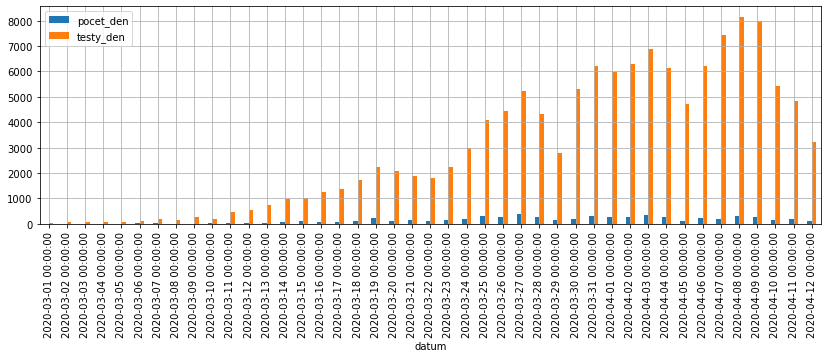

In [23]:
df.plot(kind='bar', y=['pocet_den', 'testy_den'], figsize=(14,4))
plt.show()

A ještě se koukněme, jak je to s lineární korelací ([Pearsonův korelační koeficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)). Dozvíme se, jaká je míra "lineárního vztahu" mezi jednotlivými proměnnými. Čím je hodnota bližší $1$ nebo $-1$, tím je více jedna proměnná vysvětluje druhou. Naopak hodnoty blízké 0 vyjadřují nekorelovanost, tj. nemožnost předpovědět jednu veličinu veličinou druhou prostřednictvím lineárního vztahu.

In [24]:
df.corr()

testy_den  testy_celkem  pocet_den  pocet_celkem
testy_den      1.000000      0.847715   0.883337      0.894480
testy_celkem   0.847715      1.000000   0.597699      0.991515
pocet_den      0.883337      0.597699   1.000000      0.677029
pocet_celkem   0.894480      0.991515   0.677029      1.000000

To není zlé. Podívejme se nyní konečně na to oslabení SARS-CoV2. Novinky.cz svůj nadpis o "oslabování" koronaviru doplňují zdůvodněním, že nových nakažených je nejméně za týden. Omezíme se tedy na období od poslední neděle (sic!):

In [37]:
df_tyden = df.loc['2020-04-05':'2020-04-10']

A ještě jednou koukneme na korelace, ze zvědavosti :)

In [38]:
df_tyden.corr()

testy_den  testy_celkem  pocet_den  pocet_celkem
testy_den      1.000000      0.382390   0.880390      0.388975
testy_celkem   0.382390      1.000000   0.345983      0.999340
pocet_den      0.880390      0.345983   1.000000      0.367737
pocet_celkem   0.388975      0.999340   0.367737      1.000000

Vidíme, že `testy_den` a `pocet_den` víceméně zachovaly svou hodnotu, podobně `testy_celkem` a `pocet_celkem`. Zřejmě bude korelovanost poměrně stabilní záležitostí.

Zkusme nafitovat jednoduchý lineární model - přímku ve tvaru

$$
\mathrm{pocet\_den} = \beta\cdot\mathrm{testy\_den}.
$$

Tj. potřebujeme odhadnout jediný regresní koeficient $\beta$. Připomeňme, že odhad počítáme na extrémně málo pozorováních a abychom byli fér, vynecháme už známé páteční hodnoty:

In [39]:
X = df_tyden.testy_den[:-1]
#X = sm.add_constant(X)
model = sm.OLS(endog=df_tyden.pocet_den[:-1], exog=X).fit()

In [40]:
print(model.summary2())

                       Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.973   
Dependent Variable:     pocet_den        AIC:                         51.2205 
Date:                   2020-04-13 19:23 BIC:                         50.8299 
No. Observations:       5                Log-Likelihood:              -24.610 
Df Model:               1                F-statistic:                 184.2   
Df Residuals:           4                Prob (F-statistic):          0.000171
R-squared (uncentered): 0.979            Scale:                       1379.3  
----------------------------------------------------------------------------------
                  Coef.      Std.Err.        t        P>|t|      [0.025     0.975]
----------------------------------------------------------------------------------
testy_den         0.0321       0.0024     13.5709     0.0002     0.0255     0.0386
------------------------------------------------------------

/usr/lib/python3/dist-packages/statsmodels/stats/stattools.py:70: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


`Statsmodels` nás samozřejmě varují, že tak málo pozorování nebude úplně OK pro testy, ale to nechme stranou. Dostali jsme odhad $\hat\beta=0.0321$, pomocí kterého bychom měli být z počtu testů schopni více či méně dobře predikovat počet testů pozitivních. $p$-hodnota testu 

$$
\begin{aligned}
H_0: &\quad\beta = 0 \\
H_A: &\quad\beta \ne 0
\end{aligned}
$$

je menší než 0.05, můžeme tedy nulovou hypotézu zamítnout. Ostatních testů si při daném počtu pozorování nemá smysl moc všímat, snad se jen můžeme potěšit překvapivě vysokou hodnotou [adjustovaného koeficientu determinace R](https://en.wikipedia.org/wiki/Coefficient_of_determination).

Novinky.cz se svým prohlášením o "oslabování" viru odvolávají na týdenní data. Podívejme se tedy, co náš model predikuje:

In [41]:
preds = model.get_prediction(df_tyden.testy_den).summary_frame(alpha=0.05)

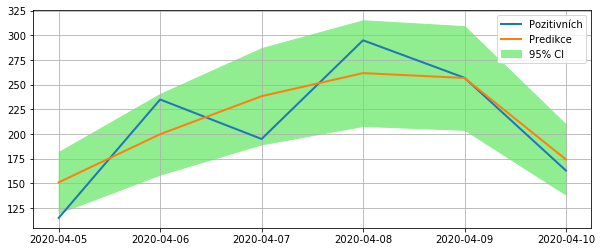

In [42]:
plt.figure(figsize=(10,4))
plt.plot(df_tyden.index, df_tyden.pocet_den, lw=2, label='Pozitivních')
plt.plot(preds.index, preds['mean'], lw=2, label='Predikce')
plt.fill_between(preds.index, preds['mean_ci_lower'], preds['mean_ci_upper'], 
                 color='lightgreen', label='95% CI')
plt.legend()

Konec nadějím, zázrak se nekoná. Absolutní počty denně provedených testů vcelku solidně determinovaly počty odhalených pozitivních případů (s přimhouřením oka, ale pracujeme na 6 měřeních ;). Predikce na pátek 10.4., kdy výrazně poklesl počet testů, bohužel ukazuje, že i počet odhalených případů klesl vcelku adekvátně. Podívejme se ještě na absolutní čísla. Následující tabulka ukazuje bodovou predikci (`mean`), její směrodatnou odchylku (`mean_se`) a horní a dolní mez konfidenčního intervalu (`mean_ci_lower` a `mean_ci_upper`).

In [47]:
preds[['mean', 'mean_se', 'mean_ci_lower', 'mean_ci_upper']]

mean    mean_se  mean_ci_lower  mean_ci_upper
datum                                                          
2020-04-05  151.019818  11.128239     120.122874     181.916761
2020-04-06  199.852765  14.726605     158.965154     240.740377
2020-04-07  238.361216  17.564188     189.595212     287.127220
2020-04-08  261.767684  19.288947     208.212982     315.322386
2020-04-09  256.797818  18.922731     204.259894     309.335741
2020-04-10  174.137713  12.831733     138.511110     209.764317

Vypišme si ještě reálné hodnoty:

In [49]:
df_tyden[['testy_den', 'pocet_den']]

testy_den  pocet_den
datum                           
2020-04-05       4710        115
2020-04-06       6233        235
2020-04-07       7434        195
2020-04-08       8164        295
2020-04-09       8009        257
2020-04-10       5431        163

Vidíme, že bodová predikce říkala 174 pozitivních, realita byla blízkých 163. Na tomto příkladu je zřetelně vidět, jak je potřeba na data nahlížet v souvislostech. Nelze se radovat z toho, že méně testů vede na menší počet odhalených pozitivních případů. Podívejme se, jak by to bylo s daným modelem pro 10, 100 a 1000 provedených testů:

In [50]:
print(model.predict(exog=[10, 100, 1000]))

[ 0.32063656  3.20636556 32.06365559]


Chtěli-li bychom přijmout uvažování v článku, při 1000 testech bychom podle (velmi hloupého) týdenního modelu čekali kolem 32 pozitivních případů. Asi to ale nebude důvod k radosti...

## Update - data za sobotu 11.4. a neděli 12.4

|den|testů|pozitivní |
|---|---|---|
|11.4.|4841|170|
|12.4.|3233|89|

Vytvoříme si tedy opět dataframe, rozšířený od poslední dva dny. Nebudeme fitovat nový model, zrecyklujeme už nafitovaný.

In [56]:
df_do_nedele = df.loc['2020-04-05':'2020-04-12']
df_do_nedele[['testy_den', 'pocet_den']]

testy_den  pocet_den
datum                           
2020-04-05       4710        115
2020-04-06       6233        235
2020-04-07       7434        195
2020-04-08       8164        295
2020-04-09       8009        257
2020-04-10       5431        163
2020-04-11       4841        170
2020-04-12       3233         89

In [57]:
preds = model.get_prediction(df_do_nedele.testy_den).summary_frame(alpha=0.05)

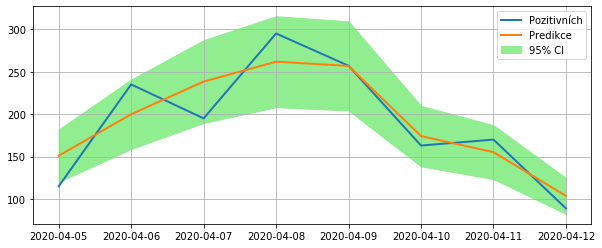

In [58]:
plt.figure(figsize=(10,4))
plt.plot(df_do_nedele.index, df_do_nedele.pocet_den, lw=2, label='Pozitivních')
plt.plot(preds.index, preds['mean'], lw=2, label='Predikce')
plt.fill_between(preds.index, preds['mean_ci_lower'], preds['mean_ci_upper'], 
                 color='lightgreen', label='95% CI')
plt.legend()

Model se tedy drží celkem pěkně. Méně testů, méně odhalených případů. Ale to sotva bude znamenat menší počet nově nakažených lidí.

**Ale ne každý to vidí takto...**

![novinky2](novinky-pondeli.png)

(novinky.cz, pondělí 13.4.2020)